# UTILS

In [15]:
import pandas as pd
import re
import string
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, precision_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

In [16]:
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

## BD3

### Pre-processing

In [17]:
df = pd.read_csv("./BD3/fake-news/train.csv")

In [18]:
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [19]:
df = df[['text', 'label']]
df

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1
...,...,...
20795,Rapper T. I. unloaded on black celebrities who...,0
20796,When the Green Bay Packers lost to the Washing...,0
20797,The Macy’s of today grew from the union of sev...,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [20]:
df = df[df['text'].apply(lambda x: isinstance(x, str))].reset_index(drop=True)

In [21]:
df["text"] = df["text"].apply(wordopt)
df

,text,label
0,house dem aide we didn t even see comey s let...,1
1,ever get the feeling your life circles the rou...,0
2,why the truth might get you fired october ...,1
3,videos civilians killed in single us airstrik...,1
4,print an iranian woman has been sentenced to ...,1
...,...,...
20756,rapper t i unloaded on black celebrities who...,0
20757,when the green bay packers lost to the washing...,0
20758,the macy s of today grew from the union of sev...,0
20759,nato russia to hold parallel exercises in bal...,1


In [22]:
X = df["text"]
y = df["label"]

In [23]:
vectorizer = TfidfVectorizer()
xv = vectorizer.fit_transform(X)
xv.shape  

(20761, 173350)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(xv, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)  

(16608, 173350)
(4153, 173350)


## Base Learners

### Decision Tree

In [25]:
param_grid_dt = {
    'max_depth': [None, 10],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 2]
}

In [26]:
dt = DecisionTreeClassifier()

In [27]:
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=5, n_jobs=-1, verbose=2)

In [30]:
grid_search_dt.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 10]},
             verbose=2)

In [31]:
with open('grid_search_dt.pkl', 'wb') as file:
    pickle.dump(grid_search_dt, file)

In [32]:
print("Melhor score de validação:", grid_search_dt.best_score_)

Melhor score de validação: 0.8829485109353735


### Logistic Regression

In [33]:
param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [100, 200]
}

In [34]:
lr = LogisticRegression()

In [35]:
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, n_jobs=-1, verbose=2)

In [36]:
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'max_iter': [100, 200],
                         'penalty': ['l2'], 'solver': ['lbfgs']},
             verbose=2)

In [37]:
with open('grid_search_lr.pkl', 'wb') as file:
    pickle.dump(grid_search_lr, file)

In [38]:
print("Melhor score de validação:", grid_search_lr.best_score_)

Melhor score de validação: 0.9564066878878703


### Naive Bayes

In [39]:
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 1.5],
    'fit_prior': [True, False]     
}

In [40]:
nb = MultinomialNB()

In [41]:
grid_search_nb = GridSearchCV(estimator=nb, param_grid=param_grid_nb, cv=5, n_jobs=-1, verbose=2)

In [42]:
grid_search_nb.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 1.5],
                         'fit_prior': [True, False]},
             verbose=2)

In [43]:
with open('grid_search_nb.pkl', 'wb') as model_file:
    pickle.dump(grid_search_nb, model_file)

In [44]:
print("Melhor score de validação:", grid_search_nb.best_score_)

Melhor score de validação: 0.9014333286017988


### SVM

In [28]:
param_grid_linear_svm = {
    'C': [0.1, 1, 10],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000, 2000, 5000]  # Opcional: ajuste conforme necessário
}


In [29]:
linear_svm = LinearSVC(random_state=42)

In [30]:
grid_search_linear_svm = GridSearchCV(estimator=linear_svm, param_grid=param_grid_linear_svm, cv=5, n_jobs=-1, verbose=2)

In [31]:
grid_search_linear_svm.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=LinearSVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'class_weight': [None, 'balanced'],
                         'max_iter': [1000, 2000, 5000]},
             verbose=2)

In [32]:
with open('grid_search_linear_svm.pkl', 'wb') as model_file:
    pickle.dump(grid_search_linear_svm, model_file)

In [33]:
print("Melhor score de validação:", grid_search_linear_svm.best_score_)

Melhor score de validação: 0.958514124173953
[CV] END ............C=0.1, class_weight=None, max_iter=1000; total time=   0.8s
[CV] END ............C=0.1, class_weight=None, max_iter=2000; total time=   0.7s
[CV] END ............C=0.1, class_weight=None, max_iter=5000; total time=   0.7s
[CV] END ........C=0.1, class_weight=balanced, max_iter=1000; total time=   0.8s
[CV] END ........C=0.1, class_weight=balanced, max_iter=2000; total time=   0.7s
[CV] END ..............C=1, class_weight=None, max_iter=1000; total time=   1.3s
[CV] END ..............C=1, class_weight=None, max_iter=2000; total time=   1.3s
[CV] END ..............C=1, class_weight=None, max_iter=5000; total time=   1.3s
[CV] END ..........C=1, class_weight=balanced, max_iter=1000; total time=   1.4s
[CV] END ..........C=1, class_weight=balanced, max_iter=2000; total time=   1.3s
[CV] END .............C=10, class_weight=None, max_iter=1000; total time=   5.0s
[CV] END .............C=10, class_weight=None, max_iter=2000; to

## Bagging

### Random Forest

In [51]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 10]
}


In [52]:
rf = RandomForestClassifier(random_state=42)

In [53]:
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)

In [54]:
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'min_samples_split': [2, 10],
                         'n_estimators': [100, 200]},
             verbose=2)

In [55]:
with open('grid_search_rf.pkl', 'wb') as file:
    pickle.dump(grid_search_rf, file)

In [56]:
print("Melhor score de validação:", grid_search_rf.best_score_)

Melhor score de validação: 0.913294832058629


## Boosting

### AdaBoost

In [57]:
param_grid_ada = {
    'n_estimators': [50, 100, 200], 
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'algorithm': ['SAMME'], 
}

In [58]:
ada = AdaBoostClassifier(random_state=42)

In [59]:
grid_search_ada = GridSearchCV(estimator=ada, param_grid=param_grid_ada, cv=5, n_jobs=-1, verbose=2)

In [60]:
grid_search_ada.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=  25.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=  21.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10; total time=  19.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10; total time=  19.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=   8.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10; total time=   8.6s
[CV] END ......C=0.1, max_iter=100, penalty=l2, solver=lbfgs; total time=   3.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lbfgs; total time=   4.9s
[CV] END ........C=1, max_iter=200, penalty=l2, solver=lbfgs; total time=   6.1s
[CV] END .......C=10, max_iter=200, penalty=l2, solver=lbfgs; total time=   9.5s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.2s
[CV] END ...............

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'algorithm': ['SAMME'],
                         'learning_rate': [0.01, 0.1, 0.5, 1],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [61]:
with open('grid_search_ada.pkl', 'wb') as f:
    pickle.dump(grid_search_ada, f)

In [62]:
print("Melhor score de validação:", grid_search_ada.best_score_)

Melhor score de validação: 0.917690409361114


### XGBoost

In [24]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'gamma': [0, 0.1]
}


In [25]:
xgb = XGBClassifier(random_state=42)

In [26]:
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)

In [ ]:
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.3min
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time= 1.3min


/home/marco/Documents/TCC/code/env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.3min
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time= 1.3min
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.3min
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time= 2.3min
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.3min
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time= 1.3min
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time= 2.4min


In [ ]:
with open('grid_search_xgb.pkl', 'wb') as f:
    pickle.dump(grid_search_xgb, f)

In [ ]:
print("Melhor score de validação:", grid_search_xgb.best_score_)

## Stacking

In [15]:
param_grid_stacking = {
    'final_estimator__C': [0.01, 0.1, 1.0, 10.0],  
    'final_estimator__solver': ['liblinear', 'saga'],  
    'passthrough': [False, True]  
}

In [16]:
with open('grid_search_dt.pkl', 'rb') as f:
    grid_search_dt = pickle.load(f)

with open('grid_search_nb.pkl', 'rb') as f:
    grid_search_nb = pickle.load(f)

with open('grid_search_lr.pkl', 'rb') as f:
    grid_search_lr = pickle.load(f)

with open('grid_search_linear_svm.pkl', 'rb') as f:
    grid_search_linear_svm = pickle.load(f)

In [17]:
base_estimators = [
    ('lr', grid_search_lr.best_estimator_),
    ('nb', grid_search_nb.best_estimator_),
    ('dt', grid_search_dt.best_estimator_),
    ('svm', grid_search_linear_svm.best_estimator_)
]

In [18]:
meta_estimator = LogisticRegression(max_iter=1000, random_state=42)

In [19]:
stacking = StackingClassifier(estimators=base_estimators, final_estimator=meta_estimator)

In [20]:
grid_search_stacking = GridSearchCV(estimator=stacking, param_grid=param_grid_stacking, cv=5, verbose=1, n_jobs=-1)

In [21]:
grid_search_stacking.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/marco/Documents/TCC/code/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marco/Documents/TCC/code/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marco/Documents/TCC/code/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marco/Documents/TCC/code/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marco/Documents/TCC/code/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home

GridSearchCV(cv=5,
             estimator=StackingClassifier(estimators=[('lr',
                                                       LogisticRegression(C=10)),
                                                      ('nb',
                                                       MultinomialNB(alpha=0.1)),
                                                      ('dt',
                                                       DecisionTreeClassifier(max_depth=10,
                                                                              min_samples_leaf=2,
                                                                              min_samples_split=10)),
                                                      ('svm',
                                                       LinearSVC(C=1,
                                                                 class_weight='balanced',
                                                                 random_state=42))],
                                          final_estimator=LogisticRegression(max_iter=1000,
                                                                             random_state=42)),
             n_jobs=-1,
             param_grid={'final_estimator__C': [0.01, 0.1, 1.0, 10.0],
                         'final_estimator__solver': ['liblinear', 'saga'],
                         'passthrough': [False, True]},
             verbose=1)

In [22]:
with open('grid_search_stacking.pkl', 'wb') as f:
    pickle.dump(grid_search_stacking, f)

In [23]:
print("Melhor score de validação:", grid_search_stacking.best_score_)

Melhor score de validação: 0.9659805760543391


# RESULTS

In [11]:
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

with open('BD3_CV_RESULTS/grid_search_dt.pkl', 'rb') as f:
    grid_search_dt = pickle.load(f)

with open('BD3_CV_RESULTS/grid_search_nb.pkl', 'rb') as f:
    grid_search_nb = pickle.load(f)

with open('BD3_CV_RESULTS/grid_search_lr.pkl', 'rb') as f:
    grid_search_lr = pickle.load(f)

with open('BD3_CV_RESULTS/grid_search_linear_svm.pkl', 'rb') as f:
    grid_search_linear_svm = pickle.load(f)

with open('BD3_CV_RESULTS/grid_search_rf.pkl', 'rb') as f:
    grid_search_rf = pickle.load(f)

with open('BD3_CV_RESULTS/grid_search_ada.pkl', 'rb') as f:
    grid_search_ada = pickle.load(f)

#with open('grid_search_xgb.pkl', 'rb') as f:
#    grid_search_xgb = pickle.load(f)

with open('BD3_CV_RESULTS/grid_search_stacking.pkl', 'rb') as f:
    grid_search_stacking = pickle.load(f)

#Extract the best models from the grid search
best_dt = grid_search_dt.best_estimator_
best_nb = grid_search_nb.best_estimator_
best_lr = grid_search_lr.best_estimator_
best_linear_svm = grid_search_linear_svm.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_ada = grid_search_ada.best_estimator_
#best_xgb = grid_search_xgb.best_estimator_
best_stacking = grid_search_stacking.best_estimator_


# Define a function to compute and print metrics
def print_metrics(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.9f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.9f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.9f}")
    print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted'):.9f}")
    print("-" * 40)

# Assuming you have the test data X_test, y_test
# Replace these with your actual test data
# X_test, y_test = ...

# Print metrics for each model
print_metrics(best_dt, X_test, y_test, 'Decision Tree')
print_metrics(best_nb, X_test, y_test, 'Naive Bayes')
print_metrics(best_lr, X_test, y_test, 'Logistic Regression')
print_metrics(best_linear_svm, X_test, y_test, 'Linear SVM')
print_metrics(best_rf, X_test, y_test, 'Random Forest')
print_metrics(best_ada, X_test, y_test, 'AdaBoost')
#print_metrics(best_xgb, X_test, y_test, 'XGBoost')
print_metrics(best_stacking, X_test, y_test, 'Stacking')

Metrics for Decision Tree:
Accuracy: 0.889477486
Precision: 0.892742513
Recall: 0.889477486
F1-Score: 0.889254201
----------------------------------------
Metrics for Naive Bayes:
Accuracy: 0.902720925
Precision: 0.909122303
Recall: 0.902720925
F1-Score: 0.902330725
----------------------------------------
Metrics for Logistic Regression:
Accuracy: 0.963159162
Precision: 0.963358767
Recall: 0.963159162
F1-Score: 0.963155672
----------------------------------------
Metrics for Linear SVM:
Accuracy: 0.965085480
Precision: 0.965218353
Recall: 0.965085480
F1-Score: 0.965083355
----------------------------------------
Metrics for Random Forest:
Accuracy: 0.910426198
Precision: 0.911063022
Recall: 0.910426198
F1-Score: 0.910389131
----------------------------------------
Metrics for AdaBoost:
Accuracy: 0.925114375
Precision: 0.925733959
Recall: 0.925114375
F1-Score: 0.925088985
----------------------------------------
Metrics for Stacking:
Accuracy: 0.970864435
Precision: 0.970904181
Recall:

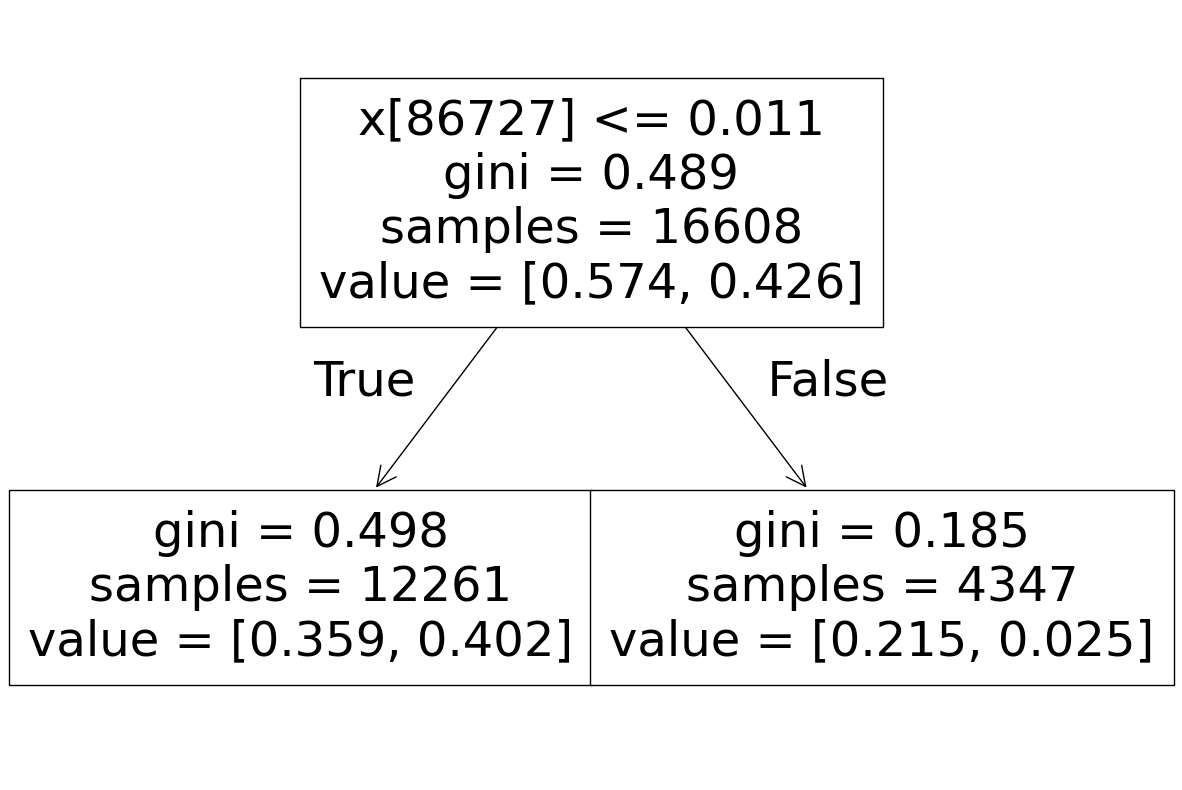

In [38]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.figure(figsize=(15, 10))
plot_tree(best_ada.estimators_[1])  # Access the first tree in the ensemble
plt.show()